In [178]:
import pandas as pd
import numpy as np
import csv
import time

## Read in the data

In [359]:
# Two .CSV files: bank-full.csv and bank.csv
# train: Bank-full.csv contains all 45,211 observations, ordered by data from May 2008 to November 2010.
# test: Bank.csv contains 10% of the observations randomly selected from bank-full.csv.
df = pd.read_csv('OCRUG/bank/bank-full.csv', delimiter=';')
# test = pd.read_csv('OCRUG/bank/bank.csv',delimiter=';')

In [13]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite.connect(db_file)
    except Error as e:
        print(e)
 
    return conn

In [17]:
# create_connection("db\raw_data.sqlite")

In [360]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [317]:
print(len(df.columns))

17


In [318]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Seperator  function

In [362]:
def update_cats(df):
    cats = []
    nums = []
    for i,j in zip(df.columns, df.dtypes):
        if j == 'int64' and i !='day' and i!='pdays':
            nums.append(i)
        else:
            cats.append(i)
    return(cats, nums)

# if j == 'object' or j == 'category

In [363]:
rets = update_cats(df)
rets[0]

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'pdays',
 'poutcome',
 'y']

In [321]:
rets[1]
#day should be cat since it's day of the week
#pdays should be cat since -1 is majority and it is not unknown, it is for people with no previous contacts (contacts=0)

['age', 'balance', 'duration', 'campaign', 'previous']

In [187]:
#below =0
# df.loc[(df['previous'] != 0) & (df['pdays'] == -1)]  

## Spot fillers for unknowns

In [188]:
#job: unknown
#education: unknown
#contact:unknown
#poutcome: unknown is non-existant in this case

#pdays: -1 means client wasn't previously contacted

#exlude duration

In [247]:
for i in df.columns:
    print("{}::::>>>{}".format(i, df[i].unique()))

age::::>>>[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
job::::>>>['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital::::>>>['married' 'single' 'divorced']
education::::>>>['tertiary' 'secondary' 'unknown' 'primary']
default::::>>>['no' 'yes']
balance::::>>>[ 2143    29     2 ...  8205 14204 16353]
housing::::>>>['yes' 'no']
loan::::>>>['no' 'yes']
contact::::>>>['unknown' 'cellular' 'telephone']
day::::>>>[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month::::>>>['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
duration::::>>>[ 261  151   76 ... 1298 1246 1556]
campaign::::>>>[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 

In [364]:
cat_imputes = ['job', 'education', 'contact', 'poutcome']
num_imputes = ['pdays']

In [365]:
for item in cat_imputes:
    print("\033[1m{}|||||||:{}".format(item, df.loc[df[item] == 'unknown',item].count()))
    pct = ((df.loc[df[item] == 'unknown',item].count())/(len(df)))
    print("missing in {}:{}%".format(item, round(pct,4)))
    print("="*30)

job|||||||:288
missing in job:0.0064%
education|||||||:1857
missing in education:0.0411%
contact|||||||:13020
missing in contact:0.288%
poutcome|||||||:36959
missing in poutcome:0.8175%


In [366]:
for item in num_imputes:
    print("\033[1m{}|||||||:{}".format(item, df.loc[df[item] == -1,item].count()))
    pct = ((df.loc[df[item] == -1,item].count())/(len(df)))
    print("codes in {}:{}%".format(item, round(pct,4)))
    print("="*30)

pdays|||||||:36954
codes in pdays:0.8174%


## Change types where necessary and correct nulls

In [367]:
df.loc[df['poutcome']=='unknown','poutcome']='DNE'
df.loc[df['job']=='unknown','job'] = np.nan
df.loc[df['education']=='unknown','education'] = np.nan
df.loc[df['contact']=='unknown','contact'] = np.nan

In [368]:
bins_day = [0,7,14,21,28,31]
df['day_bin'] = pd.cut(df['day'],bins_day)

In [369]:
df = df.replace({'month' : { 'jan' : 1, 'feb' : 2, 'mar' : 3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12 }})

In [370]:
bins = [-2, -1, 0, 400, 900]
df['pdays_bin'] = pd.cut(df['pdays'],bins)

In [196]:
def duration(data):

    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration']    = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration']   = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 644.5), 'duration'] = 4
    data.loc[data['duration']  > 644.5, 'duration'] = 5

    return data
duration(bank_related);

### campaign: how many contacts for this campaign
### pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
### previous: number of contacts prior for this client (numeric)
### poutcome: unknown is does not exist

## consider dropping pdays: previous contact 0 , pdays always -1 for no contact but when pdays -1 there is contact type information and yes tags for subscribing

## consider keeping day continous

## consider not using duration for bias

#### TEST Vals

In [20]:
df['poutcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [71]:
df.loc[df['poutcome']=='unknown',:].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [62]:
df.loc[df['pdays'] == -1, ['previous','pdays']].head()

,previous,pdays
0,0,-1
1,0,-1
2,0,-1
3,0,-1
4,0,-1


In [67]:
df.loc[(df['previous'] != 0) & (df['pdays'] == -1)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [72]:
df.loc[(df['poutcome'] == 'unknown') & (df['previous'] == 0)].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Impute 

In [371]:
# impute = ['job', 'education', 'contact']
df.loc[df['contact'].isnull(),'contact'] = 'other'
df.loc[df['education']=='unknown','education'] = 'other'

In [372]:
df.loc[df['education'].isnull(),'education'] = 'other'

In [373]:
df.loc[df['job'].isnull(),'job'] = 'other'

In [374]:
df.groupby('education')['job'].apply(lambda x: x.value_counts().head(1))

education             
other      blue-collar     454
primary    blue-collar    3758
secondary  blue-collar    5371
tertiary   management     7801
Name: job, dtype: int64

In [375]:
df.loc[(df['education'] == 'primary') & (df['job'].isnull()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'secondary') & (df['job'].isnull()), 'job'] = 'blue-collar'
df.loc[(df['education'] == 'tertiary') & (df['job'].isnull()), 'job'] = 'management'

In [376]:
df.isnull().values.any()

False

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null int64
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
day_bin      45211 non-null category
pdays_bin    45211 non-null category
dtypes: category(2), int64(8), object(9)
memory usage: 6.0+ MB


### Outliers

In [ ]:
# df = df[['balance']].mean()

# df['balance_outliers'] = df['balance']
# df['balance_outliers']= zscore(df['balance_outliers'])

# remove = (df['balance_outliers']>3) | (df['balance_outliers']<-3 )
# df = df.drop(df[remove].index, axis = 0, inplace = False)

## Reorder data

In [377]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'day_bin', 'pdays_bin'],
      dtype='object')

In [378]:
dff = df.copy()
dff = dff.drop(['day','pdays'], axis=1)
#pdays

In [379]:
order = dff.columns.tolist()[-2:] + dff.columns.tolist()[:15]

In [380]:
dff = dff[order]

### Change y to binary

In [381]:
dff['y'] = dff['y'].apply(lambda x: 0 if x=='no' else 1)

### Correlations

In [267]:
dff.corr()

,age,balance,month,duration,campaign,previous,y
age,1.000000,0.097783,0.092903,-0.004648,0.004760,0.001288,0.025155
balance,0.097783,1.000000,0.094605,0.021560,-0.014578,0.016674,0.052838
month,0.092903,0.094605,1.000000,-0.011866,0.054868,-0.035600,0.018717
duration,-0.004648,0.021560,-0.011866,1.000000,-0.084570,0.001203,0.394521
campaign,0.004760,-0.014578,0.054868,-0.084570,1.000000,-0.032855,-0.073172
previous,0.001288,0.016674,-0.035600,0.001203,-0.032855,1.000000,0.093236
y,0.025155,0.052838,0.018717,0.394521,-0.073172,0.093236,1.000000


In [268]:
import matplotlib.pyplot as plt

plt.matshow(dff.corr())
plt.show()

In [269]:
def plot_corr(df,size=10):
    '''
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    '''

    corr = dff.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

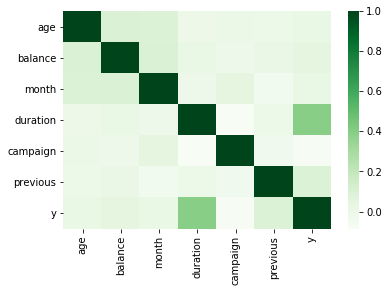

In [272]:
import seaborn as sns
corr = dff.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="Greens")

## Split data with stratified sampling

In [273]:
dff['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [279]:
dff['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [383]:
rets = update_cats(dff)
rets[0]

['day_bin',
 'pdays_bin',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

In [339]:
for i in rets[0]:
    print(dff[i].unique())

[(0, 7], (7, 14], (14, 21], (21, 28], (28, 31]]
Categories (5, interval[int64]): [(0, 7] < (7, 14] < (14, 21] < (21, 28] < (28, 31]]
[(-2, -1], (0, 400], (400, 900]]
Categories (3, interval[int64]): [(-2, -1] < (0, 400] < (400, 900]]
['management' 'technician' 'entrepreneur' 'blue-collar' 'other' 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'other' 'primary']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['other' 'cellular' 'telephone']
['DNE' 'failure' 'other' 'success']


In [384]:
dff = pd.get_dummies(dff, columns=rets[0])

In [282]:
dff['dep']=dff['y']

In [284]:
dff = dff.drop('y', axis=1)

In [288]:
indep = dff.iloc[:,:-1]
dep = dff['dep']

In [292]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(indep, dep, test_size = 0.20, random_state = 42)

k=1 84.44 (+/- 0.56)
k=2 88.07 (+/- 0.53)
k=3 87.25 (+/- 0.47)
k=4 88.20 (+/- 0.50)
k=5 87.90 (+/- 0.51)
k=6 88.36 (+/- 0.42)
k=7 88.21 (+/- 0.62)
k=8 88.49 (+/- 0.52)
k=9 88.35 (+/- 0.56)
k=10 88.54 (+/- 0.58)
k=11 88.35 (+/- 0.64)
k=12 88.49 (+/- 0.63)
k=13 88.48 (+/- 0.65)
k=14 88.58 (+/- 0.63)
k=15 88.57 (+/- 0.61)
k=16 88.60 (+/- 0.62)
k=17 88.49 (+/- 0.59)
k=18 88.61 (+/- 0.59)
k=19 88.57 (+/- 0.62)
k=20 88.68 (+/- 0.63)
k=21 88.62 (+/- 0.56)
k=22 88.66 (+/- 0.58)
k=23 88.63 (+/- 0.63)
k=24 88.69 (+/- 0.59)
k=25 88.66 (+/- 0.60)
The optimal number of neighbors is 23 with 88.7%


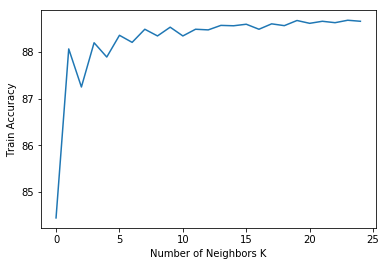

In [293]:
neighbors = np.arange(0,25)

cv_scores = []

for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print ("The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k]))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

In [296]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)

print(confusion_matrix(y_test, knnpred))
print(round(accuracy_score(y_test, knnpred),2)*100)
KNNCV = (cross_val_score(knn, X_train, y_train, cv=kfold, n_jobs=1, scoring = 'accuracy').mean())

[[7794  158]
 [ 900  191]]
88.0


In [301]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train.values, y_train.values)
xgbprd = xgb.predict(X_test.values)

print(confusion_matrix(y_test, xgbprd ))
print(round(accuracy_score(y_test, xgbprd),2)*100)
XGB = (cross_val_score(estimator = xgb, X = X_train.values, y = y_train.values, cv = 10).mean())

c:\users\ssham\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[7743  209]
 [ 700  391]]
90.0


c:\users\ssham\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\ssham\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\ssham\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\ssham\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [299]:
!pip install xgboost

You are using pip version 18.0, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [304]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)


print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=kfold, n_jobs=1, scoring = 'accuracy').mean())

[[7762  190]
 [ 729  362]]
90.0


In [306]:
from sklearn.svm import SVC
svc= SVC(kernel = 'sigmoid')
svc.fit(X_train, y_train)
svcpred = svc.predict(X_test)
print(confusion_matrix(y_test, svcpred))
print(round(accuracy_score(y_test, svcpred),2)*100)
SVCCV = (cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1, scoring = 'accuracy').mean())

[[7018  934]
 [1004   87]]
79.0


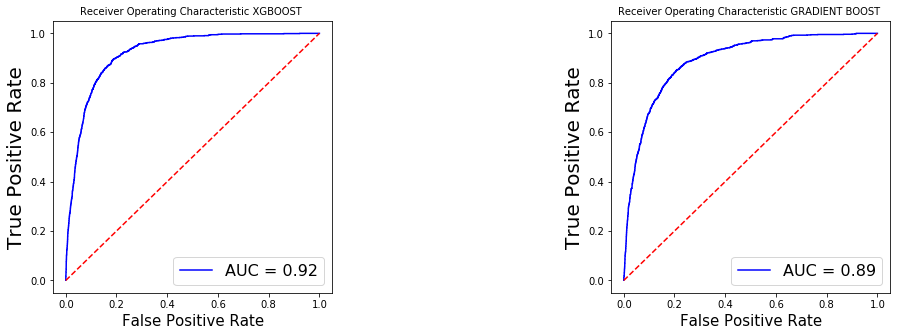

In [305]:
from sklearn import metrics

fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
probs = xgb.predict_proba(X_test.values)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_test, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic XGBOOST ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

#LR
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fprgbk, tprgbk, thresholdgbk = metrics.roc_curve(y_test, preds)
roc_aucgbk = metrics.auc(fprgbk, tprgbk)

ax1.plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic GRADIENT BOOST ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=1)
plt.savefig('ROC')

In [307]:
import pickle

# save the model to disk
filename = 'ocrug_finalized_model.sav'
pickle.dump(xgb, open(filename, 'wb'))

In [340]:
infile2=open(filename,'rb')
test=pickle.load(infile2)